In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


In [16]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [51]:
df = pd.read_csv("../../data/apple_quality.csv")

In [52]:
# prepare data
df = df.sample(frac=0.2, random_state=RANDOM_STATE)  # get only fraction of the dataset
df = df.dropna()  # remove rows that include NaNs
df["Quality"] = df["Quality"].apply(
    lambda x: 1 if x == "good" else 0
)  # good -> 1; bad -> 0
df = df.drop(columns=["A_id"], errors="ignore")
df.loc[:, df.columns != "Quality"] = MinMaxScaler().fit_transform(
    df.loc[:, df.columns != "Quality"]
)  # normalize all but Quality column

df["Acidity"] = df["Acidity"].astype("float64")

In [74]:
shuffled_df = shuffle(
    list(zip(np.array(df.loc[:, df.columns != "Quality"]), np.array(df["Quality"]))),
    random_state=RANDOM_STATE,
)
X, y = [t[0] for t in shuffled_df],[t[1] for t in shuffled_df]

training_data_percent = 0.80
training_size = int(len(X) * training_data_percent)
testing_size = len(X) - training_size
X_train, y_train = np.array(X[:training_size]), np.array(y[:training_size])
X_test, y_test = np.array(X[-testing_size:]), np.array(y[-testing_size:])

In [75]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_torch = torch.FloatTensor(X_train_scaled)
X_test_torch = torch.FloatTensor(X_test_scaled)
y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

# DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Model Definition
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = nn.Linear(7, 64)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

model = BinaryClassificationModel()

# 3. Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Confirm setup
"Dataset, Model, Loss, and Optimizer are set up. Ready to proceed with training."



'Dataset, Model, Loss, and Optimizer are set up. Ready to proceed with training.'

In [76]:
# 4. Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels.float())  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)  # Update running loss
        
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# 5. Evaluation
model.eval()  # Set the model to evaluation mode
total, correct = 0, 0
with torch.no_grad():  # Inference mode, no need to calculate gradients
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).long()  # Convert probabilities to binary output
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
accuracy


Epoch 1/20, Loss: 0.7041
Epoch 2/20, Loss: 0.6779
Epoch 3/20, Loss: 0.6542
Epoch 4/20, Loss: 0.6346
Epoch 5/20, Loss: 0.6167
Epoch 6/20, Loss: 0.6001
Epoch 7/20, Loss: 0.5844
Epoch 8/20, Loss: 0.5697
Epoch 9/20, Loss: 0.5561
Epoch 10/20, Loss: 0.5424
Epoch 11/20, Loss: 0.5301
Epoch 12/20, Loss: 0.5182
Epoch 13/20, Loss: 0.5068
Epoch 14/20, Loss: 0.4959
Epoch 15/20, Loss: 0.4860
Epoch 16/20, Loss: 0.4763
Epoch 17/20, Loss: 0.4673
Epoch 18/20, Loss: 0.4588
Epoch 19/20, Loss: 0.4505
Epoch 20/20, Loss: 0.4427


0.84375

In [80]:
results = model(X_test_torch)

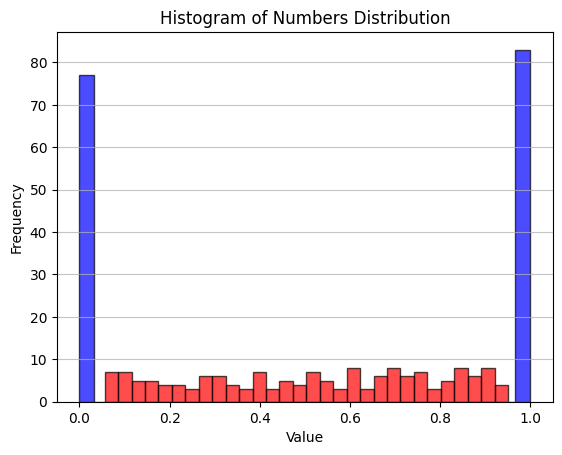

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data

# Create a histogram
plt.hist(y_test, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.hist(results.detach().numpy(), bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of Numbers Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
